# Survival Analysis in Python
### When to introduce clinical data such as gender/age?

Main source: https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb 

In [1]:
import os, six

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Packages/")
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/kim_code/")
import radiogenomics as r
import RandomSurvivalForest as rsf

# Matplotlib
import matplotlib.pyplot as plt

# Plotly
import plotly.plotly as py
import plotly.tools as tls

#Survival specific (scikit-survival)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.model_selection import train_test_split

# Scikit
from lifelines.estimation import KaplanMeierFitter
kmf = KaplanMeierFitter()
import lifelines as ll

%matplotlib inline

### Get data

In [2]:
# TCGA (gene data)
df_TCGA = r.download_data("TCGA")
df_TCGA = r.make_clean_df("TCGA", df_TCGA)

# SURVIVAL DATA
df_survival = r.create_survival_columns()

# Shapes
print("TCGA:", df_TCGA.shape)
print("df_survival:", df_survival.shape)

# Merge for complete data (only keeping subjects that are also in TCGA)
df_genes_survival = df_TCGA.join(df_survival)

# Add boolean columns for Survival Scikit 
df_genes_survival['Status_bool'] = df_genes_survival.apply(lambda row: True if (row['Status'] == 1) else False, axis=1)

# Make 4 last columns the three first
cols = df_genes_survival.columns.tolist()
cols = cols[-4:] + cols[:-4]
df_genes_survival = df_genes_survival[cols] 

print("df_genes_survival before clean:", df_genes_survival.shape)

# Drop NaN
df_genes_survival= df_genes_survival.dropna(axis='index', how='any')
print("df_genes_survival AFTER clean:", df_genes_survival.shape)

TCGA: (393, 17107)
df_survival: (562, 3)
df_genes_survival before clean: (393, 17111)
df_genes_survival AFTER clean: (363, 17111)


In [3]:
df_genes_survival

days_to_last_follow_up vital_status  Status  Status_bool POSTN  \
ID                                                                             
TCGA-02-0003                   144.0         dead     1.0         True     0   
TCGA-02-0033                    86.0         dead     1.0         True     0   
TCGA-02-0047                   448.0         dead     1.0         True     0   
TCGA-02-0055                    76.0         dead     1.0         True     0   
TCGA-02-2466                   511.0         dead     1.0         True     0   
TCGA-02-2470                   393.0         dead     1.0         True     0   
TCGA-02-2483                   466.0        alive     0.0        False     0   
TCGA-02-2485                   470.0        alive     0.0        False     0   
TCGA-02-2486                   493.0         dead     1.0         True     0   
TCGA-06-0122                     8.0         dead     1.0         True     0   
TCGA-06-0124                   123.0         dead     1.0         True     0   
TCGA-06-0125                  1439.0         dead     1.0         True     0   
TCGA-06-0126                     3.0         dead     1.0         True     0   
TCGA-06-0128                   691.0         dead     1.0         True     0   
TCGA-06-0129                   989.0         dead     1.0         True     0   
TCGA-06-0130                   320.0         dead     1.0         True     0   
TCGA-06-0132                   570.0         dead     1.0         True     0   
TCGA-06-0137                   702.0         dead     1.0         True     0   
TCGA-06-0139                   327.0         dead     1.0         True     0   
TCGA-06-0141                   280.0         dead     1.0         True     0   
TCGA-06-0145                    71.0         dead     1.0         True     0   
TCGA-06-0152                   359.0         dead     1.0         True     0   
TCGA-06-0154                   389.0         dead     1.0         True     0   
TCGA-06-0155                   263.0         dead     1.0         True     0   
TCGA-06-0157                    97.0         dead     1.0         True     0   
TCGA-06-0158                   166.0         dead     1.0         True     0   
TCGA-06-0166                   161.0         dead     1.0         True     0   
TCGA-06-0168                   579.0         dead     1.0         True     0   
TCGA-06-0169                    95.0         dead     1.0         True     0   
TCGA-06-0171                   396.0         dead     1.0         True     0   
...                              ...          ...     ...          ...   ...   
TCGA-74-6575                   636.0        alive     0.0        False     0   
TCGA-74-6577                   132.0        alive     0.0        False     0   
TCGA-74-6578                   436.0        alive     0.0        False     0   
TCGA-74-6581                   250.0        alive     0.0        False     0   
TCGA-74-6584                   228.0        alive     0.0        False     0   
TCGA-76-4925                   146.0         dead     1.0         True     0   
TCGA-76-4926                   138.0         dead     1.0         True     0   
TCGA-76-4927                   535.0         dead     1.0         True     0   
TCGA-76-4928                    94.0         dead     1.0         True     0   
TCGA-76-4929                   111.0         dead     1.0         True     0   
TCGA-76-4931                   279.0         dead     1.0         True     0   
TCGA-76-4932                  1458.0         dead     1.0         True     0   
TCGA-76-4934                    77.0         dead     1.0         True     0   
TCGA-76-4935                   328.0         dead     1.0         True     0   
TCGA-76-6191                   508.0         dead     1.0         True     0   
TCGA-76-6192                   100.0         dead     1.0         True     0   
TCGA-76-6193                    82.0         dead     1.0         True     0   
TCGA-76-6280  

### Plot survival Curve

Text(0.5,0,'time $t$')

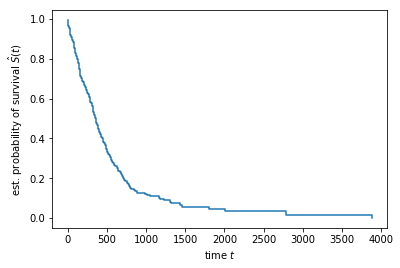

In [3]:
T = df_genes_survival['days_to_last_follow_up']   # Duration
E = df_genes_survival['Status_bool']   # dead/alive (dead=1)

# Perform kaplan_meier and plot
time, survival_prob = kaplan_meier_estimator(E, T)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Trying Random Survival Forest

In [ ]:
rd = rsf.RandomSurvivalForest(n_trees=10, 
                              max_features=2, 
                              max_depth=5, 
                              min_samples_split=2, 
                              split='auto')

In [ ]:
rd.fit(df_genes_survival.iloc[:,4:], 
       df_genes_survival[['days_to_last_follow_up', 'Status']])

In [ ]:
df = df_genes_survival.iloc[:,4:]
df['time'] = df_genes_survival['days_to_last_follow_up']

pred = rd.predict_proba(df)

### Gradient Boosting, feature selection - but VALIDATION?

In [9]:
GB = GradientBoostingSurvivalAnalysis(n_estimators=500, learning_rate=0.05, max_depth=5)

In [10]:
# Predicter variables (X)
x = df_genes_survival.iloc[:,4:].values

# Dependent variables (Y), Structured array
df = pd.DataFrame(data=[df_genes_survival['Status_bool'], 
                        df_genes_survival['days_to_last_follow_up']]).T

df['Status_bool'] = df['Status_bool'].astype('bool')
df['days_to_last_follow_up'] = df['days_to_last_follow_up'].astype('float64')

#y = [tuple(nums) for nums in df.values]
y = df.apply(lambda x: tuple(x), axis=1).values
y = np.array([num for num in y],
          dtype=[('col_1', 'bool'), ('col_2', 'float64')])



In [ ]:
# Train
GB.fit(x,y)

In [ ]:
# Get ROC score - DO I HAVE TO USE VALIDATION SET?
# Score = 1 --> Perfect model
# Score = 0 --> perfectly wrong model
# Score = 0.5 --> Random
GB.score(x, y)

### If validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42) # state is like "seed"

In [12]:
GB.fit(X_train,y_train)

GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                 learning_rate=0.05, loss='coxph', max_depth=5,
                 max_features=None, max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=1, min_samples_split=2,
                 min_weight_fraction_leaf=0.0, n_estimators=500,
                 random_state=None, subsample=1.0, verbose=0)

In [13]:
# Score close to random
GB.score(X_test, y_test)

0.5467028309883031

### Feature Importance for feature selection

In [ ]:
df_importance = pd.DataFrame(data=list(GB.feature_importances_), 
                             index=list(df_genes_survival.columns[4:]), 
                             columns=['Feature Importance'])
df_importance['Ranking'] = df_importance['Feature Importance'].rank(ascending=0)
print("Total feature importance is: ", sum(df_importance['Feature Importance']))
#GB.feature_importances_
df_importance= df_importance.loc[df_importance['Ranking'] <= 20]

In [ ]:
print(sum(df_importance['Feature Importance']))
df_importance